---
#### 5. Load and preprocess somatic mutations from [TCGA in BigQuery]
(https://bigquery.cloud.google.com/table/isb-cgc:TCGA_hg38_data_v0.Somatic_Mutation?pli=1)
<a id="tcga"></a>

- Subset query has already been completed in BQ and saved to Google Cloud Storage

In [32]:
tcga_raw = pd.read_csv(TCGA)
tcga_raw.head()

,project_short_name,case_barcode,Hugo_Symbol,Start_Position,End_Position,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,One_Consequence
0,TCGA-OV,TCGA-13-0757,C16orf82,27066866,27066867,RNA,INS,-,-,ATCCAGCTGTGAGT,non_coding_transcript_exon_variant
1,TCGA-OV,TCGA-13-1477,TUBB7P,189982710,189982711,RNA,INS,-,-,GCCTCAGTGAATTCCATCTCATCCATGCCCTCGCC,non_coding_transcript_exon_variant
2,TCGA-OV,TCGA-13-1500,PABPC1P2,146587959,146587960,RNA,INS,-,-,ACCAA,non_coding_transcript_exon_variant
3,TCGA-LUSC,TCGA-22-4591,HNRNPKP3,43263117,43263118,RNA,INS,-,-,AGAGG,non_coding_transcript_exon_variant
4,TCGA-OV,TCGA-36-2545,CTC-231O11.1,160485632,160485633,RNA,INS,-,-,ACC,non_coding_transcript_exon_variant


In [82]:
tcga_raw['Start_Position'].value_counts()

140753336    588
25245350     444
208248388    391
179234297    285
179218303    269
7675088      203
7673803      173
179218294    171
7673802      167
25245351     166
7674220      164
66568967     160
114713908    145
72893711     128
123023773    123
18210242     122
7673776      113
35904427     110
126834019    106
118176520    105
121804752    105
87965537     104
7674221      102
51380173     101
6197725       99
23310382      99
167003333     97
58357800      96
7674872       94
114339156     91
            ... 
77826388       1
2339155        1
27507026       1
102998353      1
121993562      1
70962039       1
67430374       1
232999244      1
35789158       1
157442409      1
159755333      1
14390957       1
6625670        1
232428519      1
23398788       1
182792579      1
48576898       1
111485313      1
6629760        1
52301866       1
2290043        1
84975687       1
31411192       1
31621493       1
140675444      1
112390090      1
44192111       1
73782951      

Text(0.5, 1.0, 'Distribution of Mutation Indices by Occurrence')

Text(0.5, 0, 'Mutation Index Co-occurrence')

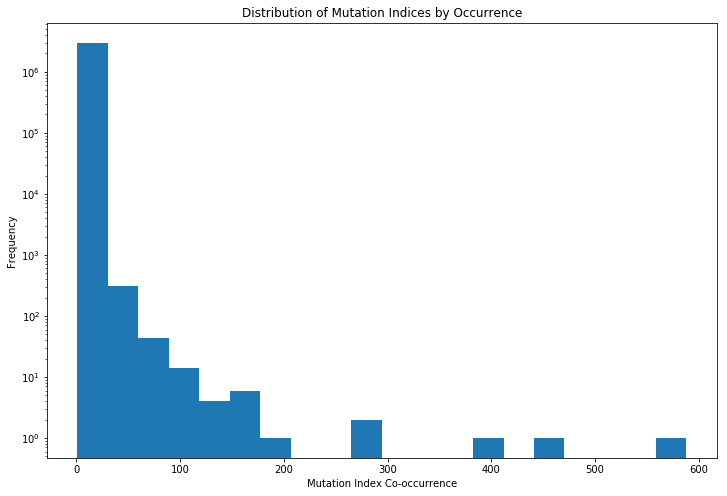

In [65]:
fig = plt.figure(figsize=(12,8)); title = 'Distribution of Mutation Indices by Occurrence'
ax = tcga_raw['Start_Position'].value_counts().plot(kind='hist', log=True,bins=20)
ax.set_title(title); ax.set_xlabel('Mutation Index Co-occurrence')
fig.savefig(FIGURES + title.lower().replace(' ','_'), dpi=fig.dpi, bbox_inches='tight', pad_inches=0.5)

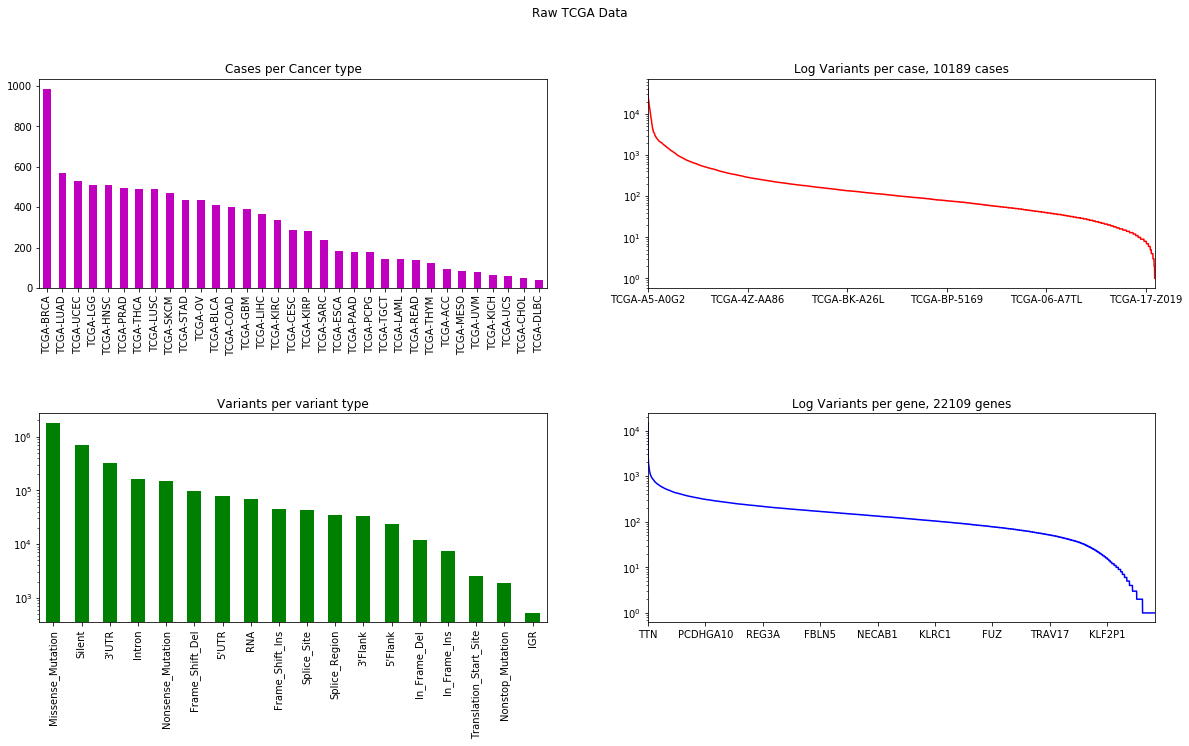

In [34]:
def visualise_distributions(df, title, savefig=True):
    """
    Plot distribution and frequency of features of interest for raw and processed TCGA df.
    """
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (20,10))
    fig.suptitle(title)
    plt.subplots_adjust(hspace=0.6)
    
    df.groupby('case_barcode').head(1)['project_short_name'].value_counts() \
        .plot(kind='bar', title='Cases per Cancer type', ax=axes[0,0], color='m')
    
    df['Variant_Classification'] \
        .value_counts().plot(kind='bar', title='Variants per variant type', ax=axes[1,0], logy=True, color='g')
    
    df['case_barcode'].value_counts() \
        .plot(title='Log Variants per case, {0:d} cases'
              .format(df['case_barcode'].value_counts().shape[0]), 
              ax=axes[0, 1],  logy=True, color='r')
    
    df['Hugo_Symbol'].value_counts() \
        .plot(title='Log Variants per gene, {0:d} genes'
              .format(df['Hugo_Symbol'].value_counts().shape[0]), 
              ax=axes[1, 1], logy=True, color='b')
    
    if savefig:
        fig.savefig(FIGURES + title.lower().replace(' ','_'), dpi=fig.dpi, bbox_inches='tight', pad_inches=0.5)
    
visualise_distributions(tcga_raw, 'Raw TCGA Data')

In absence of MutSigCV results use list of 459 driver genes from [Intogen](https://www.intogen.org/search)

In [26]:
def drop_low_mut_count(df, feature, cutoff=100):
    """
    Drop rows which contain features which occur less than cutoff times in the dataset.
    """
    subsample = df[feature].value_counts()[(df[feature].value_counts() > cutoff)].index.tolist()
    return df[df[feature].isin(subsample)]

def merge_label(df, label1, label2, merged_label):
    """
    Merge label1 and label2 into merged label within dataframe.
    """
    df.loc[(df['project_short_name'] == label1) | 
           (df['project_short_name'] == label2), 'project_short_name'] = merged_label
    return df

def process_labels(df):
    """
    Merge cancers that are established clinically to be the same.
    """
    # Colon and Rectal cancers are now considered the same cancer
    # COAD, READ -> COADREAD
    df = merge_label(df, 'TCGA-COAD', 'TCGA-READ', 'MERGE-COADREAD')
    
    # GBM and LGG are both forms of brain Glioma
    # GBM, LGG   -> GBMLGG
    df = merge_label(df, 'TCGA-GBM', 'TCGA-LGG', 'MERGE-GBMLGG')
    
    # Stomach and Esophegal cancers are also considered the same
    # ESCA, STAD -> STES
    df = merge_label(df, 'TCGA-ESCA', 'TCGA-STAD', 'MERGE-STES')
    
    return df

def filter_intogen_drivers(df):
    """
    Filter only genes that intersect with listed drivers from Intogen.
    """
    intogen_drivers = pd.read_csv(INTOGEN, sep='\t')
    driver_genes = intogen_drivers['SYMBOL'].tolist()
    return df[df['Hugo_Symbol'].isin(driver_genes)]

def filter_variants(df):
    """
    Filter out variants according to a list provided by Dr Nic Waddel (QIMR).
    """
    
    waddell_list = ['missense_variant',
                    'stop_gained',
                    'frameshift_variant',
                    'splice_acceptor_variant',
                    'splice_donor_variant',
                    'start_lost',
                    'inframe_deletion',
                    'inframe_insertion',
                    'stop_lost']
    
    return df[df['One_Consequence'].isin(waddell_list)]

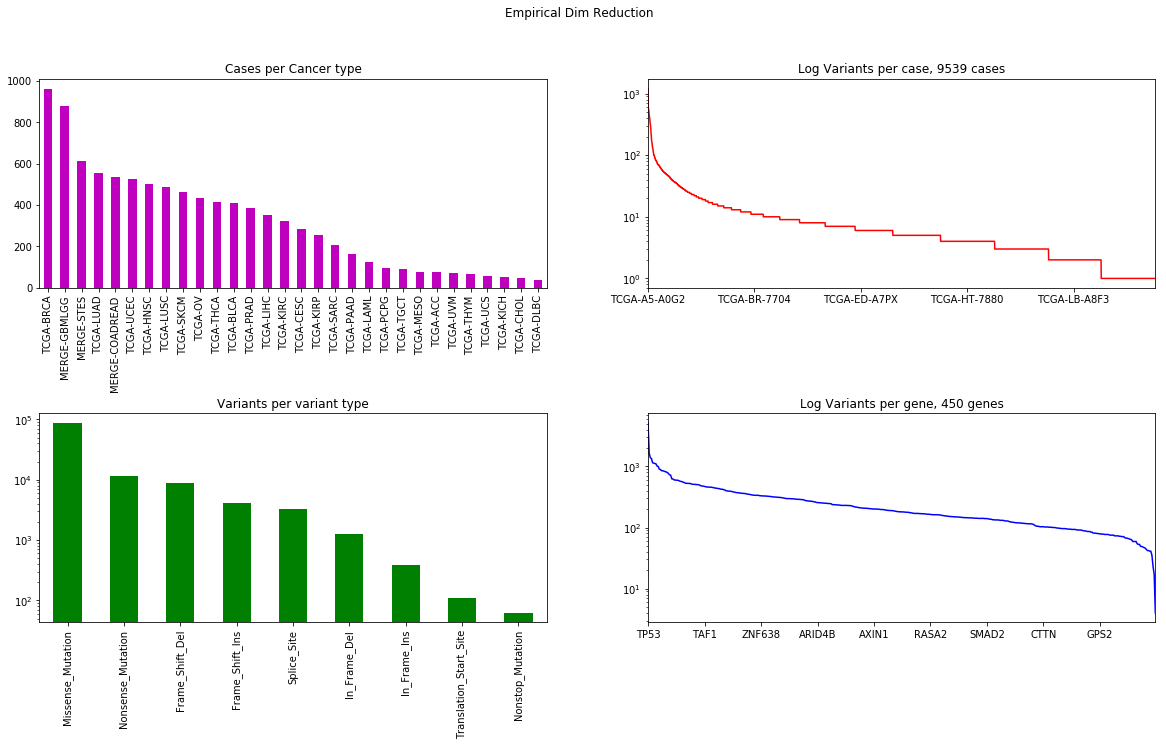

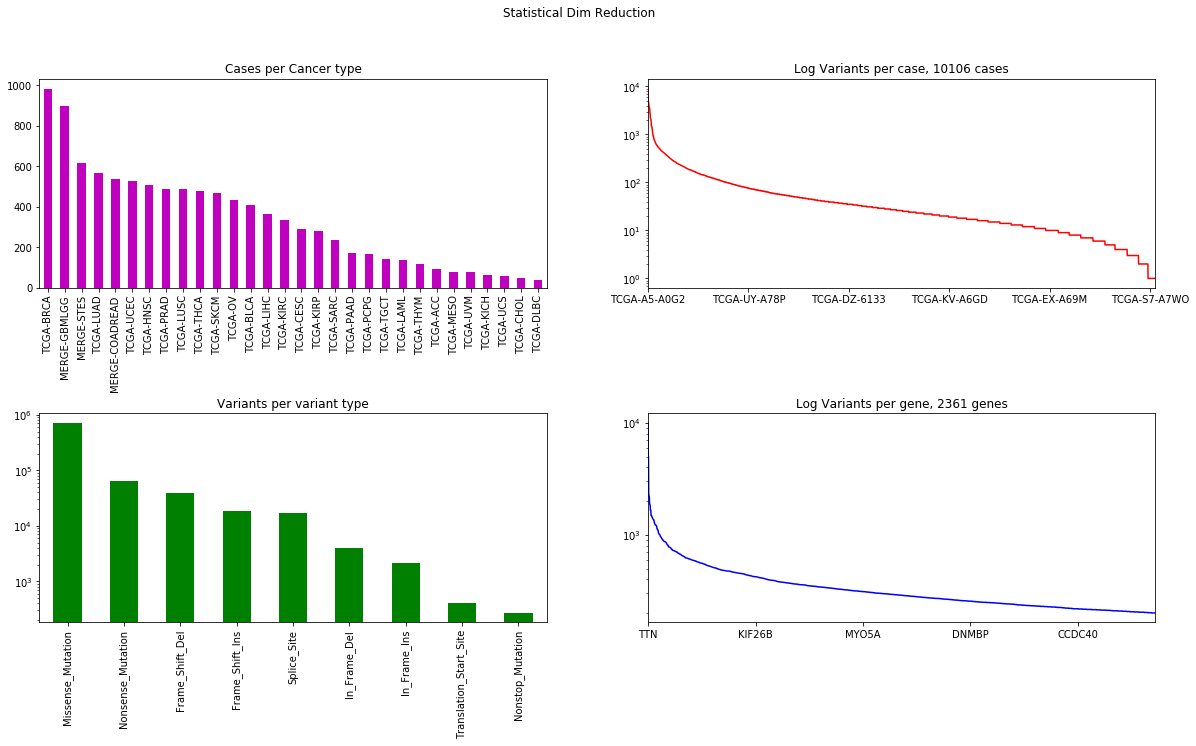

In [27]:
# empirical dim reduction
df_proc1 = (tcga_raw.pipe(process_labels)
                    .pipe(filter_variants)
                    .pipe(filter_intogen_drivers))

# statistical dim reductions
df_proc2 = (tcga_raw.pipe(process_labels)
                    .pipe(filter_variants)
                    .pipe(drop_low_mut_count, 'Hugo_Symbol', 200))     # naïvely remove very genes with few mutations as noise

visualise_distributions(df_proc1, 'Empirical Dim Reduction')
visualise_distributions(df_proc2, 'Statistical Dim Reduction')

In [28]:
def dedup_and_get_variant_count(df_in):
    """
    Deduplicate gene sample combinations with >1 mutations and aggregate 
    with additional feature of variant count for gene sample combination.
    """
    df = df_in.copy()
    
    counts = df.groupby('case_barcode')['Hugo_Symbol'].value_counts()
    df = df.drop_duplicates(subset=['case_barcode', 'Hugo_Symbol'])
    df = df.set_index(['case_barcode', 'Hugo_Symbol'])
    df['mutation_count'] = counts
    df = df.reset_index()
    
    return df

def reshape_pivot(df_in):
    """
    Reduce df to crucial subset then pivot on cases and genes.
    """
    df = (df_in[['case_barcode', 'Hugo_Symbol', 'mutation_count']]
              .copy()
              .pivot(index='case_barcode', columns='Hugo_Symbol', values='mutation_count')
              .fillna(0)
              .astype(int))
    
    return df

def get_label_df(df_in, df_X):
    """
    Get label df from flat processed df.
    """
    df_y = (df_in.loc[df_in['case_barcode'].isin(df_X.index)]
                 .groupby('case_barcode')
                 .head(1)
                 .set_index('case_barcode')[['project_short_name']]
                 .sort_index())
    return df_y

In [29]:
# Get processed dataframes ready for training
df_X1 = (df_proc1.pipe(dedup_and_get_variant_count)
                 .pipe(reshape_pivot))

df_X2 = (df_proc2.pipe(dedup_and_get_variant_count)
                 .pipe(reshape_pivot))

df_y1 = (df_proc1.pipe(get_label_df, df_X1))
df_y2 = (df_proc2.pipe(get_label_df, df_X2))

In [126]:
df_X1.head()
df_X2.head()
df_y1.head()
df_y2.head()

Hugo_Symbol,ABL2,ACACA,ACAD8,ACO1,ACSL3,ACSL6,ACTB,ACTG1,ACTG2,ACVR1B,...,YBX1,ZC3H11A,ZFHX3,ZFP36L1,ZFP36L2,ZMYM2,ZNF292,ZNF638,ZNF750,ZNF814
case_barcode,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-02-0033,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-02-0047,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-02-0055,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-02-2466,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Hugo_Symbol,A1CF,A2M,A2ML1,AASDH,AASS,ABCA1,ABCA10,ABCA12,ABCA13,ABCA2,...,ZNF845,ZNF91,ZNF98,ZNF99,ZNFX1,ZP4,ZSCAN20,ZSWIM2,ZSWIM8,ZZEF1
case_barcode,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-02-0033,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
TCGA-02-0047,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-02-0055,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-02-2466,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,project_short_name
case_barcode,
TCGA-02-0003,MERGE-GBMLGG
TCGA-02-0033,MERGE-GBMLGG
TCGA-02-0047,MERGE-GBMLGG
TCGA-02-0055,MERGE-GBMLGG
TCGA-02-2466,MERGE-GBMLGG


,project_short_name
case_barcode,
TCGA-02-0003,MERGE-GBMLGG
TCGA-02-0033,MERGE-GBMLGG
TCGA-02-0047,MERGE-GBMLGG
TCGA-02-0055,MERGE-GBMLGG
TCGA-02-2466,MERGE-GBMLGG


In [127]:
df_X1.shape
df_y1.shape

(9539, 450)

(9539, 1)